In [538]:
import os
from netCDF4 import Dataset
from wrf import to_np, getvar, smooth2d, get_cartopy, cartopy_xlim, cartopy_ylim, latlon_coords, ALL_TIMES
import numpy as np
from PIL import Image
from mpl_toolkits.basemap import Basemap, cm
import matplotlib.pyplot as plt
from datetime import datetime
os.chdir('/home/diego/Documentos/IDEAM/IDEAM_ETo/')

In [21]:
%%timeit
# Abro el archivo nc
nc_name='20190901_m1.nc'
ncfile = Dataset(nc_name) #importa archivo netcdf

1.98 ms ± 82.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [63]:
# Imprimo las variables y su información
for i in ncfile.variables:
    print('------------------------------------------------')
    print(i)
    try:
        print(ncfile.variables[i].description)
        print(ncfile.variables[i].units)
        print(ncfile.variables[i].coordinates)
    except AttributeError:
        continue

------------------------------------------------
Times
------------------------------------------------
XLAT
LATITUDE, SOUTH IS NEGATIVE
degree_north
XLONG XLAT
------------------------------------------------
XLONG
LONGITUDE, WEST IS NEGATIVE
degree_east
XLONG XLAT
------------------------------------------------
LU_INDEX
LAND USE CATEGORY

XLONG XLAT XTIME
------------------------------------------------
ZNU
eta values on half (mass) levels

------------------------------------------------
ZNW
eta values on full (w) levels

------------------------------------------------
ZS
DEPTHS OF CENTERS OF SOIL LAYERS
m
------------------------------------------------
DZS
THICKNESSES OF SOIL LAYERS
m
------------------------------------------------
VAR_SSO
variance of subgrid-scale orography
m2
XLONG XLAT XTIME
------------------------------------------------
U
x-wind component
m s-1
XLONG_U XLAT_U XTIME
------------------------------------------------
V
y-wind component
m s-1
XLONG_V XLAT_V XT

In [104]:
# Creo objeto de fechas
Fechas = []
for i in ncfile.variables['Times']:
    Fechas.append(datetime.strptime(''.join([j.decode('UTF-8') for j in i]), '%Y-%m-%d_%H:%M:%S' ))

In [545]:

mes = 10 # Mes para hacer el cálculo

meses = list(np.arange(1, 13, 1))
meses.extend(meses) # Lista expandida con el número del mes

lowIndex = [i.month for i in Fechas].index(meses[mes - 1]) # Index inferior donde está el mes
upIndex = [i.month for i in Fechas].index(meses[mes]) # Index superior donde está el mes

T = ncfile.variables['T2'][lowIndex:upIndex]  # Temperaturas para todo el mes actual

# Tempetura media del mes siguiente
try:
    Tmes_siguiente = np.mean(ncfile.variables['T2'][[i.month for i in Fechas].index(meses[mes]):
                                           [i.month for i in Fechas].index(meses[mes + 1])], axis=0)
except ValueError:
    Tmes_siguiente = None

# Temperatura media del mes anterior
try:
    Tmes_anterior = np.mean(ncfile.variables['T2'][[i.month for i in Fechas].index(meses[mes - 2]):
                                           [i.month for i in Fechas].index(meses[mes - 1])], axis=0)
except ValueError:
    Tmes_anterior = None

Tmaxdia = np.empty(shape=(T.shape[0]//4,) + T.shape[1:])  #Para almacenar las temperaturas extremas diarias
Tmindia = np.empty(shape=(T.shape[0]//4,) + T.shape[1:])
for i, j in enumerate(np.arange(0, T.shape[0], 4)):
    Tmaxdia[i] = np.max(T[j:j+4], axis=0) 
    Tmindia[i] = np.min(T[j:j+4], axis=0)

Tmax = np.mean(Tmaxdia, axis=0) # Temperatura máxima media mensual(K)
Tmin = np.mean(Tmindia, axis=0) # Temperatura mínima media mensual(K)
Tmed = np.mean(T, axis=0) # Temperatura media mensual del mes actual(K)

# Cálculo del flujo mensual de calor
if Tmes_anterior is None:
    Tmes_anterior = Tmed  # Si no dispone del raster con la temperatura media mensual del mes anterior
if Tmes_siguiente is None:
    G = 0.14*(Tmed - Tmes_anterior)
else: 
    G = 0.07*(Tmes_siguiente - Tmes_anterior)

In [526]:
HR = np.ma.empty(shape=(upIndex - lowIndex,) + ncfile.variables['T2'].shape[1:]) # Humedad relativa (%)
for j, i in enumerate(range(lowIndex, upIndex)):
    HR[j] =(getvar(ncfile, 'rh2', timeidx=i))
HR = np.mean(HR, axis=0)

In [527]:
ws10 = np.ma.empty(shape=(upIndex - lowIndex,) + ncfile.variables['T2'].shape[1:3]) # Velocidad del viento a 10m (m/s)
for j, i in enumerate(range(lowIndex, upIndex)):
    ws10[j] =(getvar(ncfile, 'wspd10', timeidx=i))
ws10 = np.mean(ws10, axis=0)
u2 = 0.665*ws10  # Velocidad del viento a 2m (m/s)

In [528]:
P = Tmax = np.mean(ncfile.variables['PSFC'][lowIndex:upIndex], axis=0)  # Presión atmosférica (Pa)
P = P/1000.  # Presión atmosférica (kPa)

In [529]:
Rsi = ncfile.variables['ACSWDNB'][upIndex] - \
      ncfile.variables['ACSWDNB'][lowIndex]  # Radiación de onda corta entrante acumulada mensual (J/m2)
Rli = ncfile.variables['ACLWDNB'][upIndex] - \
      ncfile.variables['ACLWDNB'][lowIndex]  # Radiación de onda larga entrante acumulada mensual (J/m2)
Rlo = ncfile.variables['ACLWUPB'][upIndex] - \
      ncfile.variables['ACLWUPB'][lowIndex]  # Radiación de onda larga saliente acumulada mensual (J/m2)

albedo = 0.23  # Albedo de la superficie de referencia
Rn = (1 - albedo)*Rsi + Rli - Rlo  # Radiación neta mensual (J/m2)
Rn = Rn/1e6  # Radiación neta mensual (MJ/m2)

In [630]:
gamma = 0.665e-3 * P  # Constante psicrométrica (kPa °C-1)

def eo(T):
    return 0.6108 * np.exp((17.27 * T - 273.15)/(T - 273.15 + 237.3))

es = (eo(Tmax) + eo(Tmin))/2  # Presión de vapor de saturación media mensual (kPa)
ea = (HR/100) * es  # Presión real del vapor media mensual (kPa)
Delta = (4098 * 0.6108 * np.exp((17.27 * Tmed - 273.15)/
                                (Tmed - 273.15 + 237.3)))/(Tmed - 273.15 + 237.3)**2 # Pendiente de la curva de presión de vapor

In [547]:
#Cálculo de la ETo (mm/mes)
ETo = ((0.408 * Delta * (Rn - G) + gamma * (900/(Tmed)) * u2 * (es - ea))/
      (Delta + gamma * (1 + 0.34 * u2)))

/home/diego/anaconda2/envs/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
/home/diego/anaconda2/envs/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
/home/diego/anaconda2/envs/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.


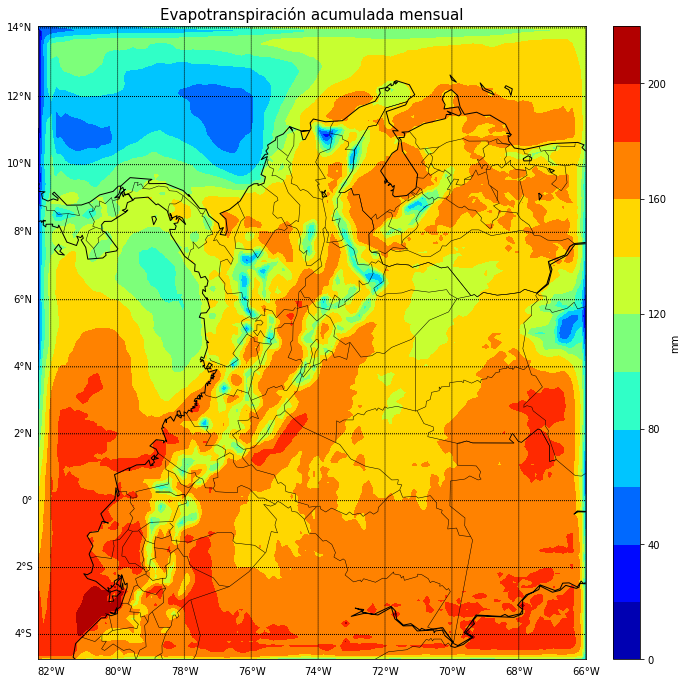

In [636]:
data = ETo
fig = plt.figure(figsize=(11,11))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
m = Basemap(projection='merc',lon_0=-74.1,lat_0=4.63,lat_ts=4.63,\
            llcrnrlat=ncfile['XLAT'][:][0][0][0],urcrnrlat=ncfile['XLAT'][:][0][-1][0],\
            llcrnrlon=ncfile['XLONG'][:][0][0][0],urcrnrlon=ncfile['XLONG'][:][0][0][-1],\
            rsphere=6371200.,resolution='l',area_thresh=100)
m.drawcoastlines()
m.drawstates()
m.drawcountries()

# draw parallels.
parallels = np.arange(-90.,90,2.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,2.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

ny = data.shape[0]; nx = data.shape[1]
lons, lats = m.makegrid(nx, ny) # get lat/lons of ny by nx evenly space grid.
x, y = m(lons, lats) # compute map proj coordinates.

# draw filled contours.
clevs = np.arange(0, 240, 20)
cs = m.contourf(x,y,data,clevs,cmap='jet')
# add colorbar.
cbar = m.colorbar(cs,location='right',pad="5%")
cbar.set_label('mm')
# add title
plt.title('Evapotranspiración acumulada mensual', 
         fontsize=15)
plt.show()

/home/diego/anaconda2/envs/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
/home/diego/anaconda2/envs/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
/home/diego/anaconda2/envs/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.


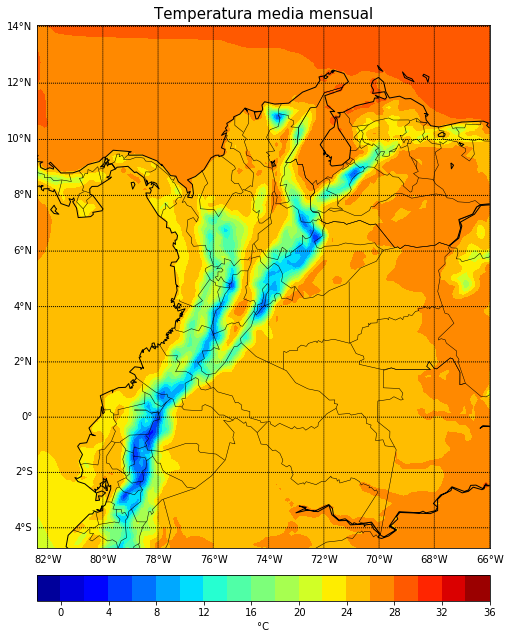

In [609]:
data = Tmed - 273.15
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
m = Basemap(projection='merc',lon_0=-74.1,lat_0=4.63,lat_ts=4.63,\
            llcrnrlat=ncfile['XLAT'][:][0][0][0],urcrnrlat=ncfile['XLAT'][:][0][-1][0],\
            llcrnrlon=ncfile['XLONG'][:][0][0][0],urcrnrlon=ncfile['XLONG'][:][0][0][-1],\
            rsphere=6371200.,resolution='l',area_thresh=100)
m.drawcoastlines()
m.drawstates()
m.drawcountries()

# draw parallels.
parallels = np.arange(-90.,90,2.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,2.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

ny = data.shape[0]; nx = data.shape[1]
lons, lats = m.makegrid(nx, ny) # get lat/lons of ny by nx evenly space grid.
x, y = m(lons, lats) # compute map proj coordinates.

# draw filled contours.
clevs = np.arange(-2, 38, 2)
cs = m.contourf(x,y,data,clevs,cmap='jet')
# add colorbar.
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('°C')
# add title
plt.title('Temperatura media mensual', 
         fontsize=15)
plt.show()

/home/diego/anaconda2/envs/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
/home/diego/anaconda2/envs/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
/home/diego/anaconda2/envs/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.


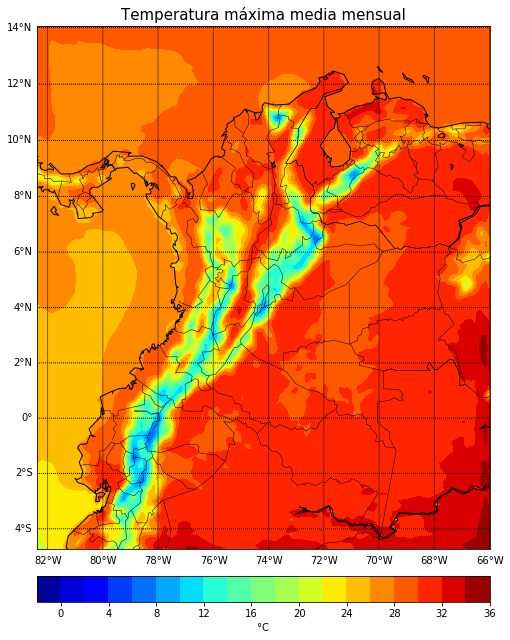

In [631]:
data = Tmax - 273.15
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
m = Basemap(projection='merc',lon_0=-74.1,lat_0=4.63,lat_ts=4.63,\
            llcrnrlat=ncfile['XLAT'][:][0][0][0],urcrnrlat=ncfile['XLAT'][:][0][-1][0],\
            llcrnrlon=ncfile['XLONG'][:][0][0][0],urcrnrlon=ncfile['XLONG'][:][0][0][-1],\
            rsphere=6371200.,resolution='l',area_thresh=100)
m.drawcoastlines()
m.drawstates()
m.drawcountries()

# draw parallels.
parallels = np.arange(-90.,90,2.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,2.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

ny = data.shape[0]; nx = data.shape[1]
lons, lats = m.makegrid(nx, ny) # get lat/lons of ny by nx evenly space grid.
x, y = m(lons, lats) # compute map proj coordinates.

# draw filled contours.
clevs = np.arange(-2, 38, 2)
cs = m.contourf(x,y,data,clevs,cmap='jet')
# add colorbar.
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('°C')
# add title
plt.title('Temperatura máxima media mensual', 
         fontsize=15)
plt.show()

/home/diego/anaconda2/envs/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
/home/diego/anaconda2/envs/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
/home/diego/anaconda2/envs/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.


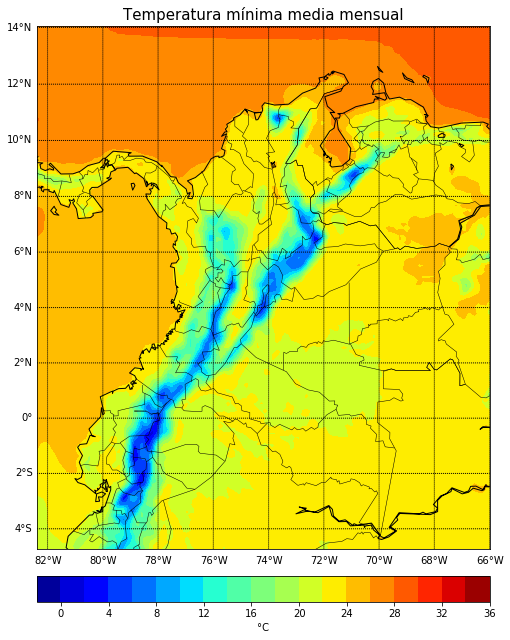

In [612]:
data = Tmin - 273.15
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
m = Basemap(projection='merc',lon_0=-74.1,lat_0=4.63,lat_ts=4.63,\
            llcrnrlat=ncfile['XLAT'][:][0][0][0],urcrnrlat=ncfile['XLAT'][:][0][-1][0],\
            llcrnrlon=ncfile['XLONG'][:][0][0][0],urcrnrlon=ncfile['XLONG'][:][0][0][-1],\
            rsphere=6371200.,resolution='l',area_thresh=100)
m.drawcoastlines()
m.drawstates()
m.drawcountries()

# draw parallels.
parallels = np.arange(-90.,90,2.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,2.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

ny = data.shape[0]; nx = data.shape[1]
lons, lats = m.makegrid(nx, ny) # get lat/lons of ny by nx evenly space grid.
x, y = m(lons, lats) # compute map proj coordinates.

# draw filled contours.
clevs = np.arange(-2, 38, 2)
cs = m.contourf(x,y,data,clevs,cmap='jet')
# add colorbar.
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('°C')
# add title
plt.title('Temperatura mínima media mensual', 
         fontsize=15)
plt.show()

/home/diego/anaconda2/envs/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
/home/diego/anaconda2/envs/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
/home/diego/anaconda2/envs/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.


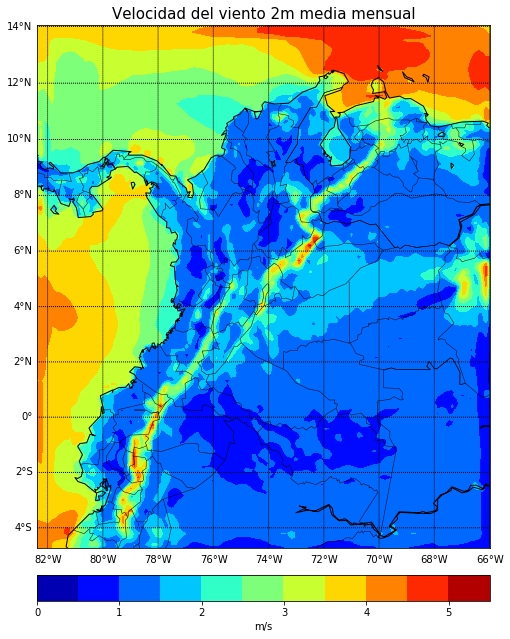

In [613]:
data = u2
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
m = Basemap(projection='merc',lon_0=-74.1,lat_0=4.63,lat_ts=4.63,\
            llcrnrlat=ncfile['XLAT'][:][0][0][0],urcrnrlat=ncfile['XLAT'][:][0][-1][0],\
            llcrnrlon=ncfile['XLONG'][:][0][0][0],urcrnrlon=ncfile['XLONG'][:][0][0][-1],\
            rsphere=6371200.,resolution='l',area_thresh=100)
m.drawcoastlines()
m.drawstates()
m.drawcountries()

# draw parallels.
parallels = np.arange(-90.,90,2.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,2.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

ny = data.shape[0]; nx = data.shape[1]
lons, lats = m.makegrid(nx, ny) # get lat/lons of ny by nx evenly space grid.
x, y = m(lons, lats) # compute map proj coordinates.

# draw filled contours.
clevs = np.arange(0, 6, 0.5)
cs = m.contourf(x,y,data,clevs,cmap='jet')
# add colorbar.
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('m/s')
# add title
plt.title('Velocidad del viento 2m media mensual', 
         fontsize=15)
plt.show()

/home/diego/anaconda2/envs/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
/home/diego/anaconda2/envs/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
/home/diego/anaconda2/envs/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.


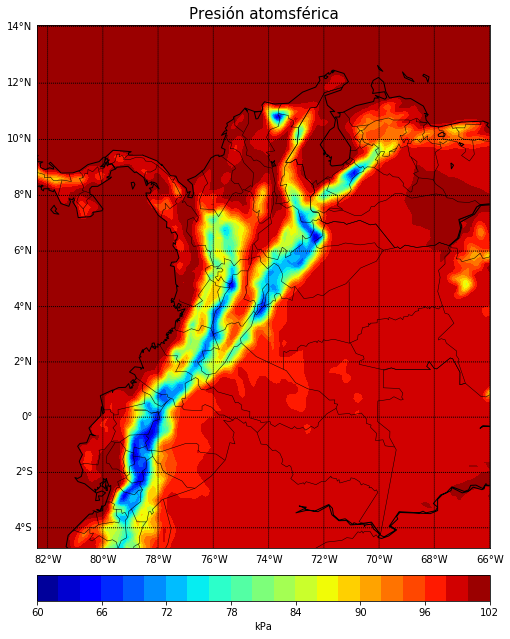

In [614]:
data = P
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
m = Basemap(projection='merc',lon_0=-74.1,lat_0=4.63,lat_ts=4.63,\
            llcrnrlat=ncfile['XLAT'][:][0][0][0],urcrnrlat=ncfile['XLAT'][:][0][-1][0],\
            llcrnrlon=ncfile['XLONG'][:][0][0][0],urcrnrlon=ncfile['XLONG'][:][0][0][-1],\
            rsphere=6371200.,resolution='l',area_thresh=100)
m.drawcoastlines()
m.drawstates()
m.drawcountries()

# draw parallels.
parallels = np.arange(-90.,90,2.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,2.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

ny = data.shape[0]; nx = data.shape[1]
lons, lats = m.makegrid(nx, ny) # get lat/lons of ny by nx evenly space grid.
x, y = m(lons, lats) # compute map proj coordinates.

# draw filled contours.
clevs = np.arange(60, 104, 2)
cs = m.contourf(x,y,data,clevs,cmap='jet')
# add colorbar.
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('kPa')
# add title
plt.title('Presión atomsférica', 
         fontsize=15)
plt.show()

/home/diego/anaconda2/envs/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
/home/diego/anaconda2/envs/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
/home/diego/anaconda2/envs/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.


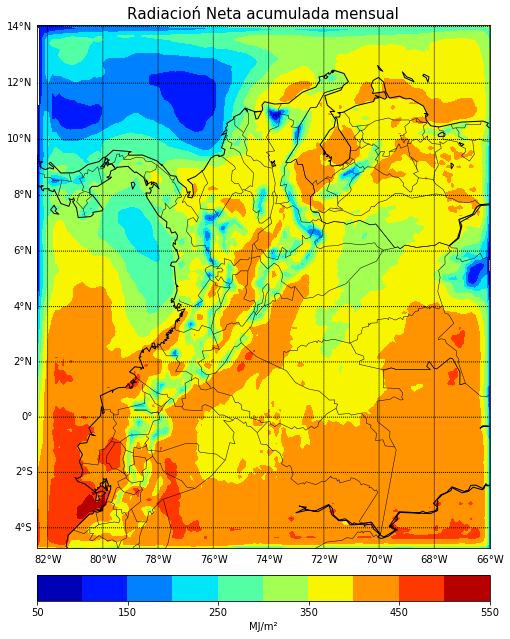

In [627]:
data = Rn
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
m = Basemap(projection='merc',lon_0=-74.1,lat_0=4.63,lat_ts=4.63,\
            llcrnrlat=ncfile['XLAT'][:][0][0][0],urcrnrlat=ncfile['XLAT'][:][0][-1][0],\
            llcrnrlon=ncfile['XLONG'][:][0][0][0],urcrnrlon=ncfile['XLONG'][:][0][0][-1],\
            rsphere=6371200.,resolution='l',area_thresh=100)
m.drawcoastlines()
m.drawstates()
m.drawcountries()

# draw parallels.
parallels = np.arange(-90.,90,2.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,2.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

ny = data.shape[0]; nx = data.shape[1]
lons, lats = m.makegrid(nx, ny) # get lat/lons of ny by nx evenly space grid.
x, y = m(lons, lats) # compute map proj coordinates.

# draw filled contours.
clevs = np.arange(50, 600, 50)
cs = m.contourf(x,y,data,clevs,cmap='jet')
# add colorbar.
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('MJ/m²')
# add title
plt.title('Radiacioń Neta acumulada mensual', 
         fontsize=15)
plt.show()

/home/diego/anaconda2/envs/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
/home/diego/anaconda2/envs/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
/home/diego/anaconda2/envs/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.


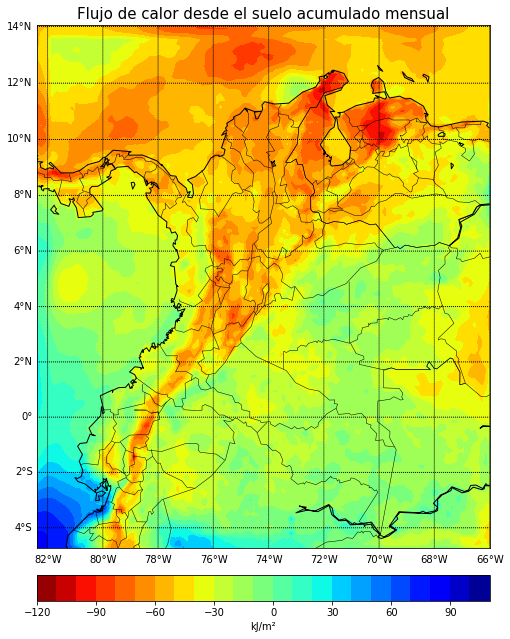

In [629]:
data = G * 1e3
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
m = Basemap(projection='merc',lon_0=-74.1,lat_0=4.63,lat_ts=4.63,\
            llcrnrlat=ncfile['XLAT'][:][0][0][0],urcrnrlat=ncfile['XLAT'][:][0][-1][0],\
            llcrnrlon=ncfile['XLONG'][:][0][0][0],urcrnrlon=ncfile['XLONG'][:][0][0][-1],\
            rsphere=6371200.,resolution='l',area_thresh=100)
m.drawcoastlines()
m.drawstates()
m.drawcountries()

# draw parallels.
parallels = np.arange(-90.,90,2.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,2.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

ny = data.shape[0]; nx = data.shape[1]
lons, lats = m.makegrid(nx, ny) # get lat/lons of ny by nx evenly space grid.
x, y = m(lons, lats) # compute map proj coordinates.

# draw filled contours.
clevs = np.arange(-120, 120, 10)
cs = m.contourf(x,y,data,clevs,cmap='jet_r')
# add colorbar.
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('kJ/m²')
# add title
plt.title('Flujo de calor desde el suelo acumulado mensual', 
         fontsize=15)
plt.show()